# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [5]:

import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders
city_config_mapping = {
    "Manhattan": "Manhattan_config",
    "Atlanta": "Atlanta_config",
    "Phoenix_SM": "PHX_SM",
    "Phoenix_PV": "PHX_PV",
}

# Rainfall files you want
rainfall_files = [5]  # Only 5 and 6

# Generate sim_names
sim_names = []
for city, config in city_config_mapping.items():
    for rain_id in rainfall_files:
        sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
        sim_names.append(sim_name)

print(f"Training on {len(sim_names)} simulations.")
for s in sim_names:
    print(s)

# Now load dataset
train_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='train'
).cache()

validation_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='val'
).cache()

# Now you can pass these into your model training like usual


2025-08-28 14:31:36.977452: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 14:31:37.731738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 14:31:37.731837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 14:31:37.858245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 14:31:38.107318: I tensorflow/core/platform/cpu_feature_guar

Training on 4 simulations.
Manhattan-Manhattan_config/Rainfall_Data_5.txt
Atlanta-Atlanta_config/Rainfall_Data_5.txt
Phoenix_SM-PHX_SM/Rainfall_Data_5.txt
Phoenix_PV-PHX_PV/Rainfall_Data_5.txt


2025-08-28 14:31:45.175637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


# ATLANTA_PREDICTION DATA LOADING

In [21]:
from pathlib import Path
from usl_models.flood_ml import constants
from usl_models.flood_ml.dataset import download_dataset, load_prediction_dataset_cached


In [22]:
filecache_dir = Path("./filecache")
sim_names = ["Atlanta_Prediction"]

print("📥 Downloading Atlanta_Prediction into local cache...")
download_dataset(
    sim_names=sim_names,
    output_path=filecache_dir,
    dataset_splits=["train"],   # ignored for prediction sims
)
print("✅ Download complete.")


📥 Downloading Atlanta_Prediction into local cache...
[Prediction] Inputs-only download for: Atlanta_Prediction
[Prediction] Inputs-only download for: Atlanta_Prediction
  Trying prefix: gs://test-climateiq-study-area-feature-chunks/Atlanta_Prediction/
    ✓ Atlanta_Prediction/scaled_chunk_0_0.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_0.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_1.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_1.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_2.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_2.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_3.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_3.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_4.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_4.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_5.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_5.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_6.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_6.npy
    ✓ Atlanta_Prediction/scaled_chunk_1_0.npy -> fileca

In [23]:
print("📦 Loading Atlanta_Prediction dataset (features only)...")

ds_pred = load_prediction_dataset_cached(
    filecache_dir=filecache_dir,
    sim_name="Atlanta_Prediction",
    batch_size=4,
    n_flood_maps=constants.N_FLOOD_MAPS,
    m_rainfall=constants.M_RAINFALL,
)

# Sanity check: Take 1 batch
for features, meta in ds_pred.take(1):
    print("Feature keys:", list(features.keys()))
    print("geospatial:", features["geospatial"].shape)
    print("temporal:", features["temporal"].shape)
    print("spatiotemporal:", features["spatiotemporal"].shape)
    print("metadata:", {k: (v.numpy() if hasattr(v, "numpy") else v) for k, v in meta.items()})


📦 Loading Atlanta_Prediction dataset (features only)...
Feature keys: ['geospatial', 'temporal', 'spatiotemporal']
geospatial: (4, 1000, 1000, 9)
temporal: (4, 864, 6)
spatiotemporal: (4, 5, 1000, 1000, 1)
metadata: {'feature_chunk': array([b'scaled_chunk_0_0', b'scaled_chunk_0_1', b'scaled_chunk_0_2',
       b'scaled_chunk_0_3'], dtype=object), 'rainfall': array([864, 864, 864, 864], dtype=int32)}


In [7]:

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
    ),
        objective="val_loss",
        max_trials=1,
        project_name=f"logs/htune_project_{timestamp}",
)

tuner.search_space_summary()


Search space summary
Default search space size: 6
lstm_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
lstm_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
lstm_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
n_flood_maps (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
m_rainfall (Choice)
{'default': 6, 'conditions': [], 'values': [6], 'ordered': True}


In [19]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_dataset, epochs=1, validation_data=validation_dataset , callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

logs/htune_project_20250828-143143


{'lstm_units': 64,
 'lstm_kernel_size': 3,
 'lstm_dropout': 0.3,
 'lstm_recurrent_dropout': 0.3,
 'n_flood_maps': 5,
 'm_rainfall': 6}

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define final parameters and model
final_params = FloodModel.Params(**best_hp.values)
model = FloodModel(params=final_params)

# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf"
    ),
    EarlyStopping(               # <--- ADD THIS
        monitor="val_loss",       # What to monitor
        patience=10,              # Number of epochs with no improvement to wait
        restore_best_weights=True, # Restore model weights from best epoch
        mode="min"                # "min" because lower val_loss is better
    )
]

# Train
model.fit(
    train_dataset,
    validation_dataset,
    epochs=200,
    callbacks=callbacks
)

# Save final model
model.save_model(log_dir + "/model")


Epoch 1/200


2025-08-28 15:29:52.579288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflood_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_1/flood_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    159/Unknown - 39s 212ms/step - loss: 0.0046 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0677

2025-08-28 15:30:27.905064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14272831848944551806
2025-08-28 15:30:27.905129: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4751065413172252277
2025-08-28 15:30:34.490442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2271233806428099311
2025-08-28 15:30:34.490487: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7293818549871070001
2025-08-28 15:30:34.490497: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9389099547201225591
2025-08-28 15:30:34.490506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2019068851213402586
2025-08-28 15:30:34.490528: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 49s 278ms/step - loss: 0.0046 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0677 - val_loss: 0.0032 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0570
Epoch 2/200
159/159 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0520WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0027 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0520 - val_loss: 0.0027 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0515
Epoch 3/200
159/159 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0485WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 45s 282ms/step - loss: 0.0024 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0485 - val_loss: 0.0024 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0491
Epoch 4/200
159/159 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0467WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 274ms/step - loss: 0.0022 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0467 - val_loss: 0.0022 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0474
Epoch 5/200
159/159 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0452WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 44s 277ms/step - loss: 0.0020 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0452 - val_loss: 0.0021 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0461
Epoch 6/200
159/159 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0440WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0019 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0440 - val_loss: 0.0020 - val_mean_absolute_error: 0.0102 - val_root_mean_squared_error: 0.0450
Epoch 7/200
159/159 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0107 - root_mean_squared_error: 0.0431WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 274ms/step - loss: 0.0019 - mean_absolute_error: 0.0107 - root_mean_squared_error: 0.0431 - val_loss: 0.0019 - val_mean_absolute_error: 0.0100 - val_root_mean_squared_error: 0.0441
Epoch 8/200
159/159 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0105 - root_mean_squared_error: 0.0423WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 44s 277ms/step - loss: 0.0018 - mean_absolute_error: 0.0105 - root_mean_squared_error: 0.0423 - val_loss: 0.0019 - val_mean_absolute_error: 0.0098 - val_root_mean_squared_error: 0.0433
Epoch 9/200
159/159 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0104 - root_mean_squared_error: 0.0415WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0017 - mean_absolute_error: 0.0104 - root_mean_squared_error: 0.0415 - val_loss: 0.0018 - val_mean_absolute_error: 0.0099 - val_root_mean_squared_error: 0.0427
Epoch 10/200
159/159 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0104 - root_mean_squared_error: 0.0413WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 44s 277ms/step - loss: 0.0017 - mean_absolute_error: 0.0104 - root_mean_squared_error: 0.0413 - val_loss: 0.0018 - val_mean_absolute_error: 0.0097 - val_root_mean_squared_error: 0.0420
Epoch 11/200
159/159 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0403WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0403 - val_loss: 0.0017 - val_mean_absolute_error: 0.0096 - val_root_mean_squared_error: 0.0414
Epoch 12/200
159/159 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0399WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0399 - val_loss: 0.0017 - val_mean_absolute_error: 0.0094 - val_root_mean_squared_error: 0.0409
Epoch 13/200
159/159 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0397WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 44s 277ms/step - loss: 0.0016 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0397 - val_loss: 0.0016 - val_mean_absolute_error: 0.0094 - val_root_mean_squared_error: 0.0404
Epoch 14/200
159/159 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0391WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 274ms/step - loss: 0.0015 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0391 - val_loss: 0.0016 - val_mean_absolute_error: 0.0093 - val_root_mean_squared_error: 0.0399
Epoch 15/200
159/159 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0386WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0386 - val_loss: 0.0016 - val_mean_absolute_error: 0.0091 - val_root_mean_squared_error: 0.0395
Epoch 16/200
159/159 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0384WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 44s 277ms/step - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0384 - val_loss: 0.0015 - val_mean_absolute_error: 0.0091 - val_root_mean_squared_error: 0.0391
Epoch 17/200
159/159 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0379WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0014 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0379 - val_loss: 0.0015 - val_mean_absolute_error: 0.0090 - val_root_mean_squared_error: 0.0387
Epoch 18/200
159/159 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0378WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250828-143143/checkpoint/assets


159/159 [==============================] - 43s 273ms/step - loss: 0.0014 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0378 - val_loss: 0.0015 - val_mean_absolute_error: 0.0090 - val_root_mean_squared_error: 0.0383
Epoch 19/200
 92/159 [================>.............] - ETA: 14s - loss: 0.0021 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0463

KeyboardInterrupt: 

In [10]:
# # Test calling the model on some data.
inputs, labels_ = next(iter(train_dataset))
prediction = model.call(inputs)
prediction.shape

TensorShape([4, 1000, 1000, 1])

In [11]:

import tensorflow as tf
# Path to your saved model
model_path = "/home/vupparal/climateiq-cnn-2/logs/htune_project_20250828-143143/model"

# Load the model
model = tf.keras.models.load_model(model_path)

In [12]:
# # Test calling the model for n predictions
#full_dataset = load_dataset(sim_names=sim_names, batch_size=1,dataset_split="test")
#inputs, labels = next(iter(full_dataset))
#predictions = model.call_n(inputs, n=4)
#predictions.shape

2025-08-28 14:53:27.616246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/body/_130/while/mul_10' -> 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/body/_130/while/add_5', 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/next_iteration/_173-0-0-TransposeNCHWToNHWC-LayoutOptimizer' -> 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/merge/_146'}.



Sample 1 Prediction Stats:
  Min: 0.0
  Max: 0.298465
  Mean: 0.0023359335


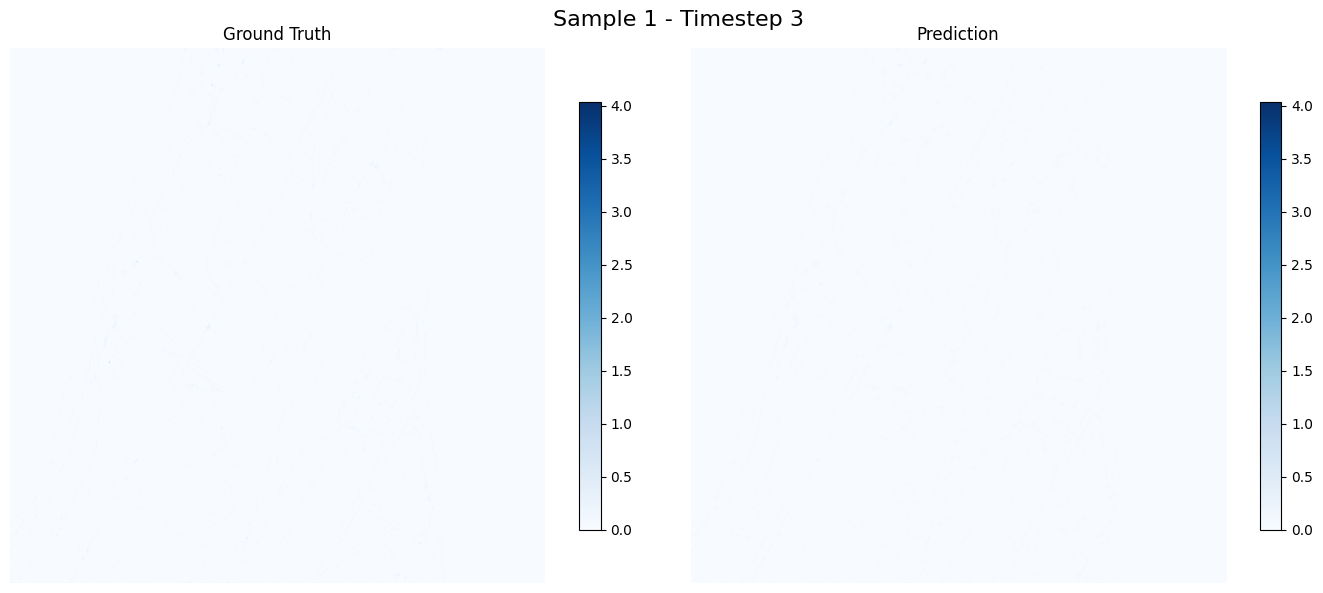


Sample 2 Prediction Stats:
  Min: 0.0
  Max: 4.9624767
  Mean: 0.022372968


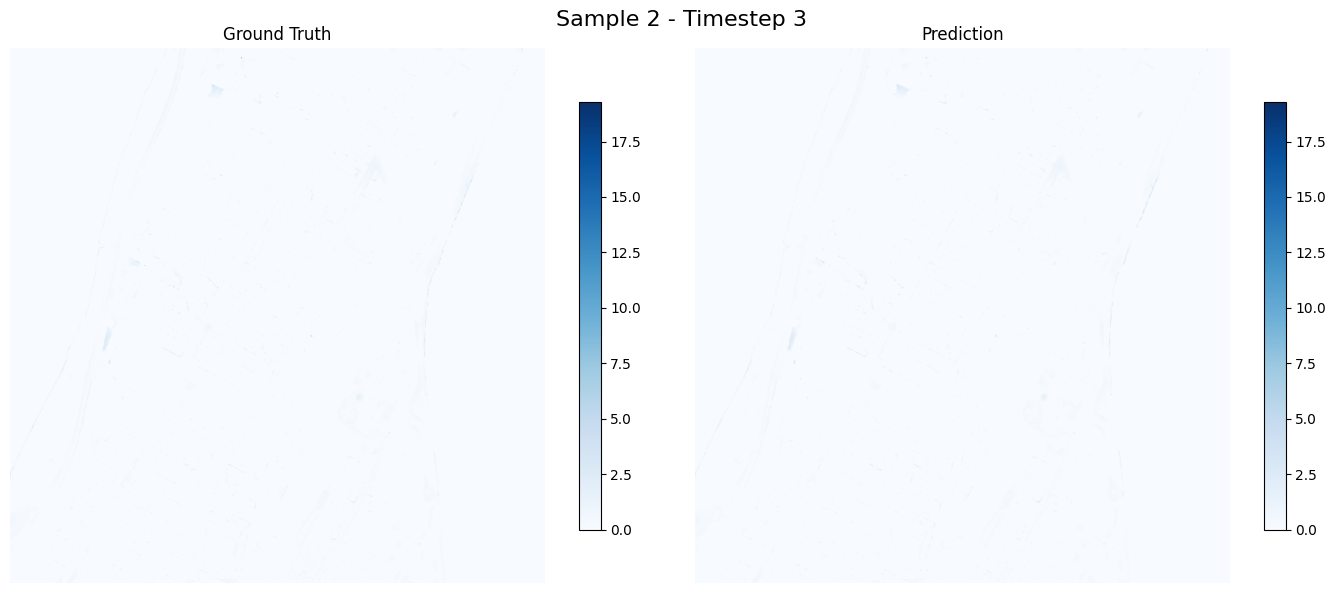


Sample 3 Prediction Stats:
  Min: 0.0
  Max: 6.3985844
  Mean: 0.032456264


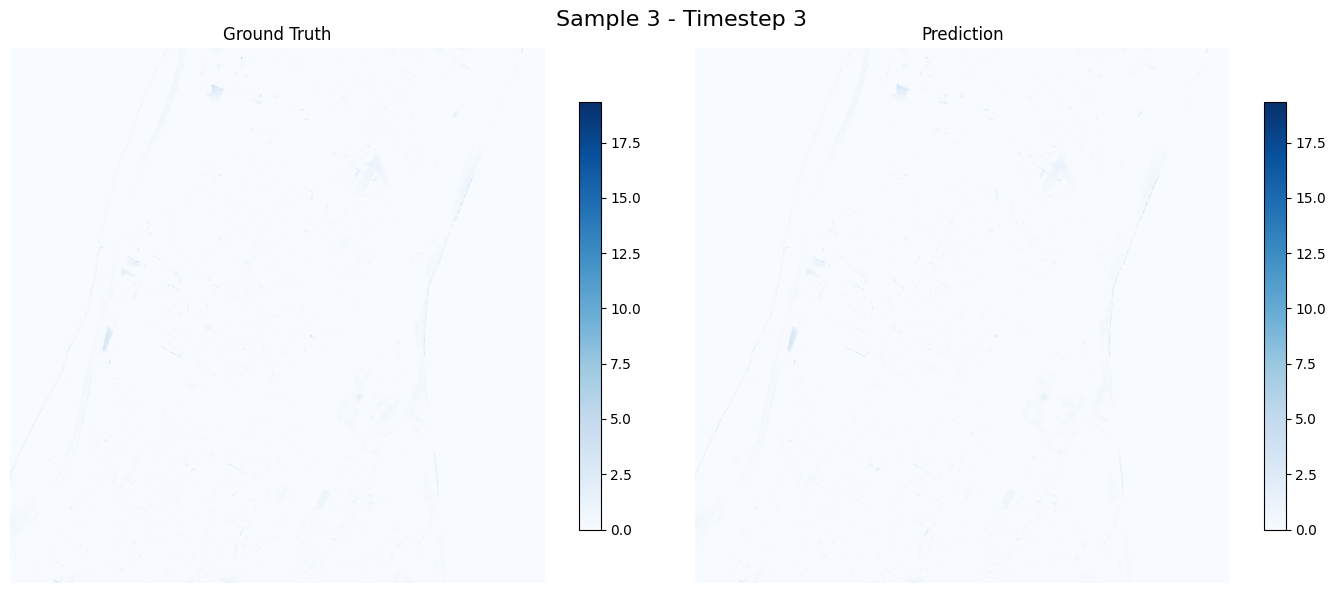


Sample 4 Prediction Stats:
  Min: 0.0
  Max: 6.415124
  Mean: 0.0094902115


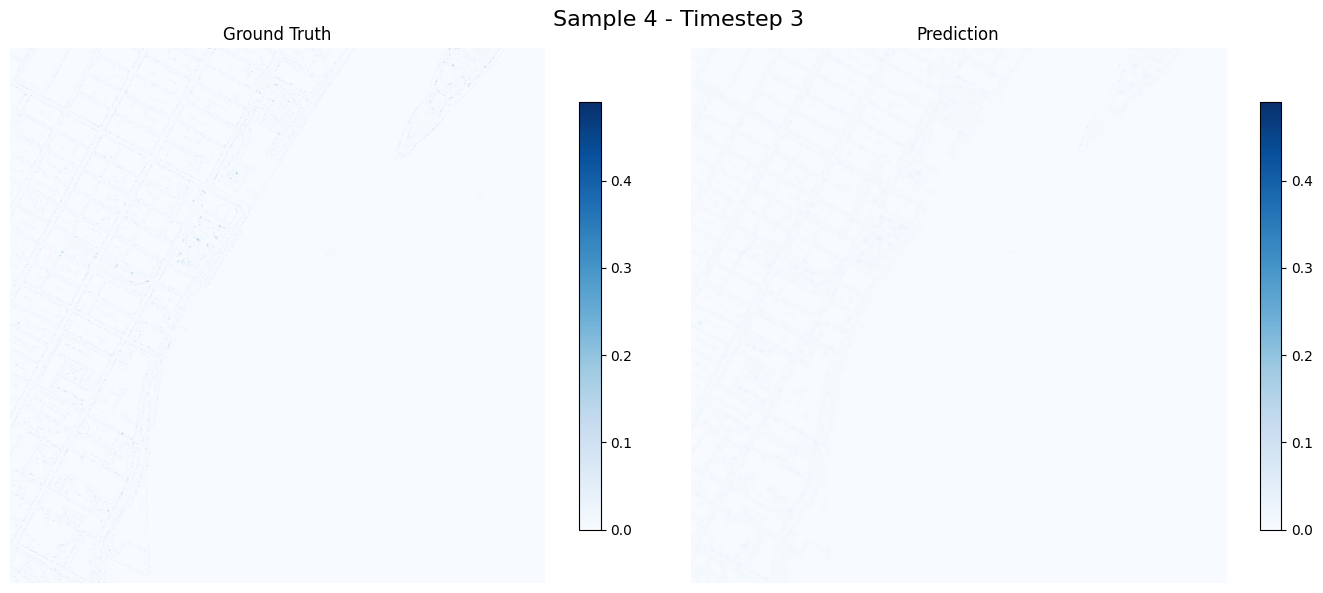


Sample 5 Prediction Stats:
  Min: 0.0
  Max: 3.4724157
  Mean: 0.010264329


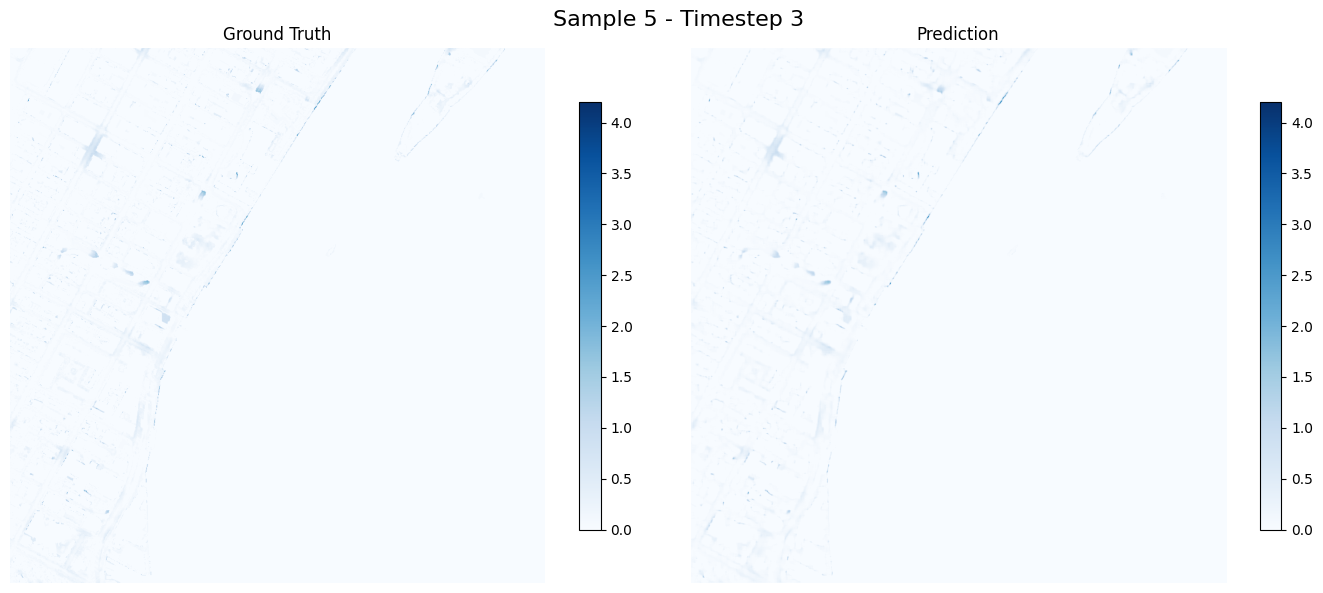


Sample 6 Prediction Stats:
  Min: 0.0
  Max: 4.382109
  Mean: 0.01958033


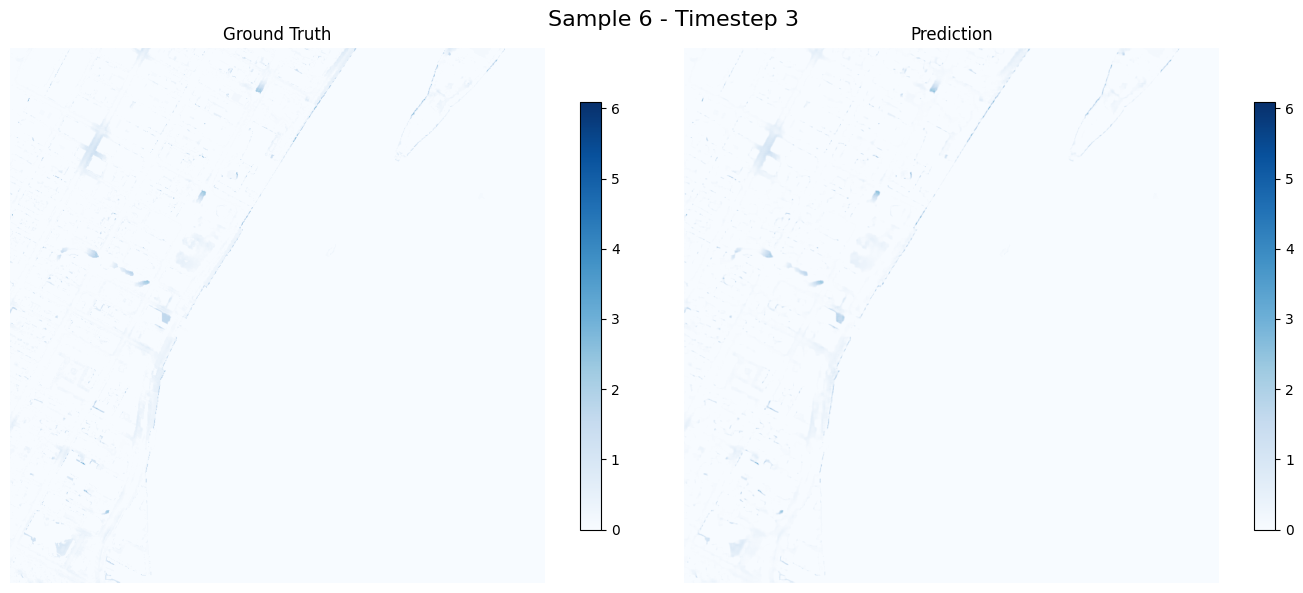


Sample 7 Prediction Stats:
  Min: 0.0
  Max: 4.6689568
  Mean: 0.011617937


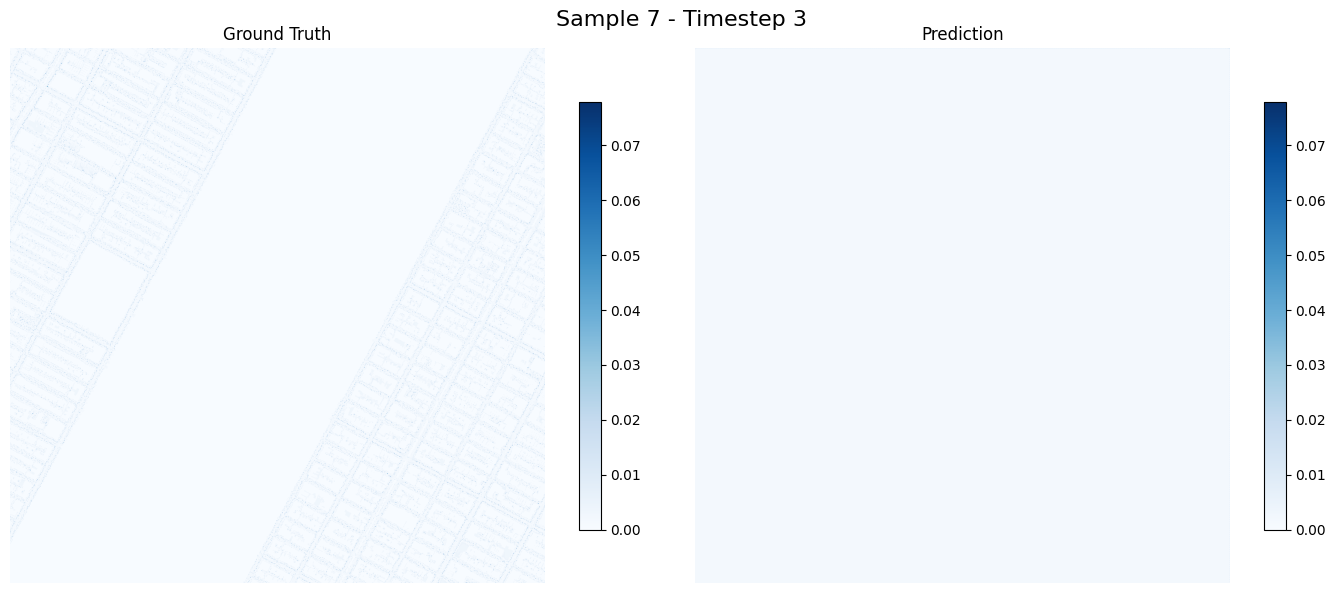


Sample 8 Prediction Stats:
  Min: 0.0
  Max: 2.0273626
  Mean: 0.012443587


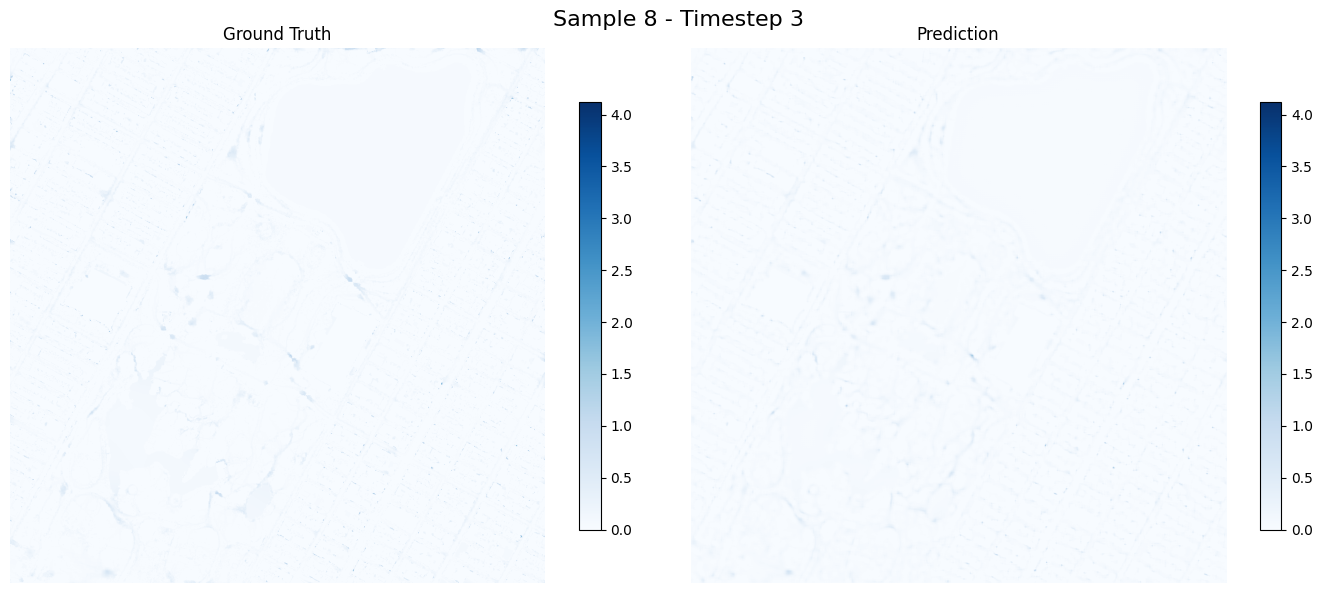


Sample 9 Prediction Stats:
  Min: 0.0
  Max: 4.0859437
  Mean: 0.037304666


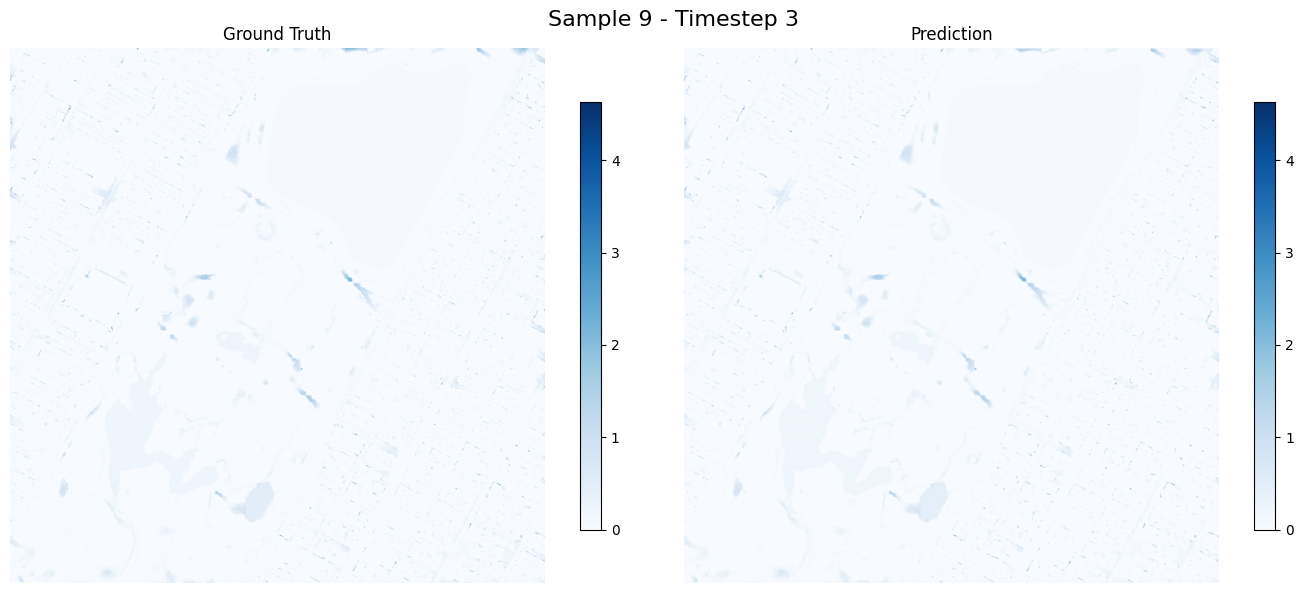


Sample 10 Prediction Stats:
  Min: 0.0
  Max: 4.020526
  Mean: 0.031140607


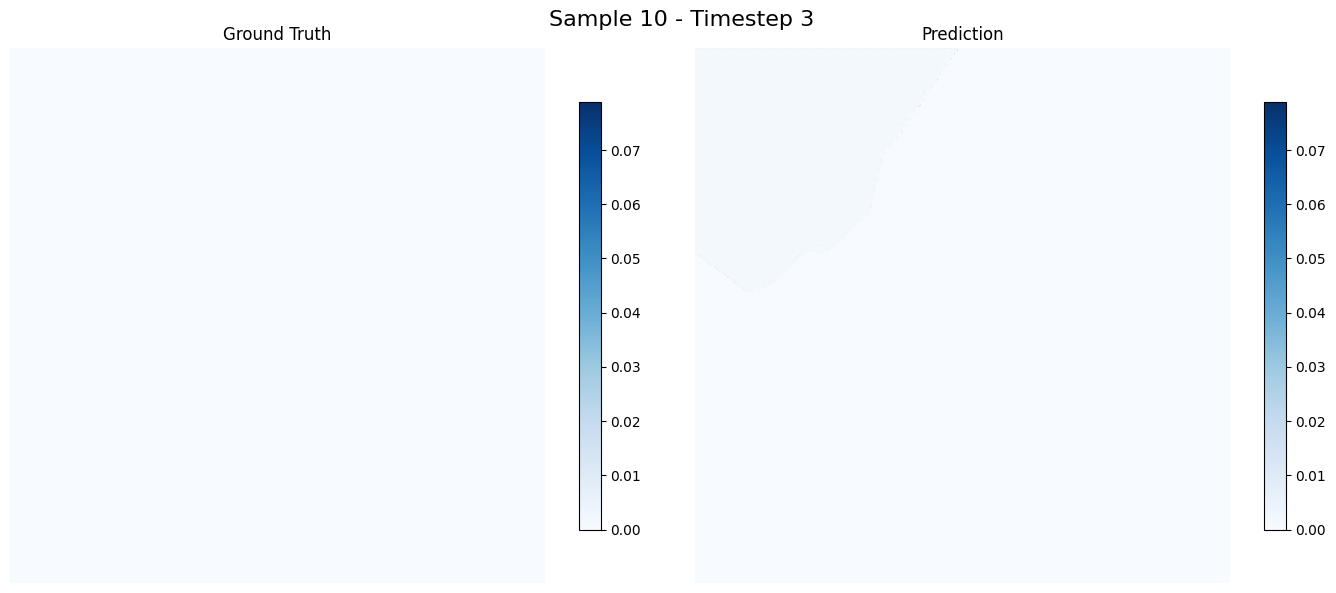


Sample 11 Prediction Stats:
  Min: 0.0
  Max: 0.985525
  Mean: 0.00076355156


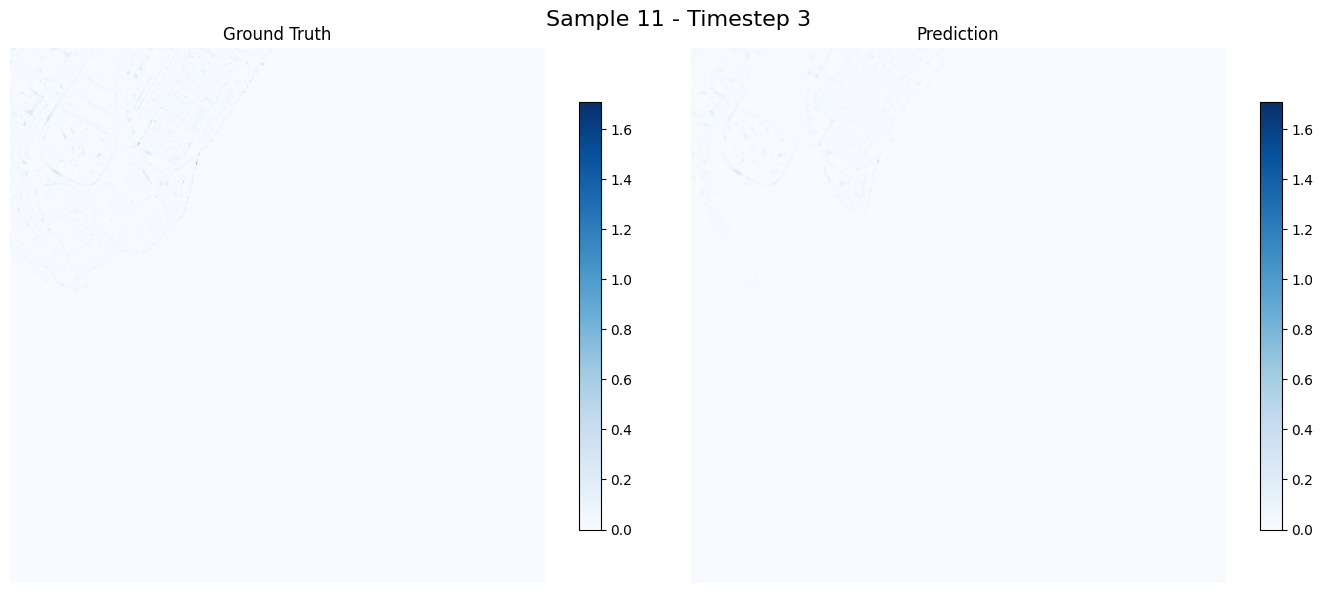


Sample 12 Prediction Stats:
  Min: 0.0
  Max: 4.1560974
  Mean: 0.0057705804


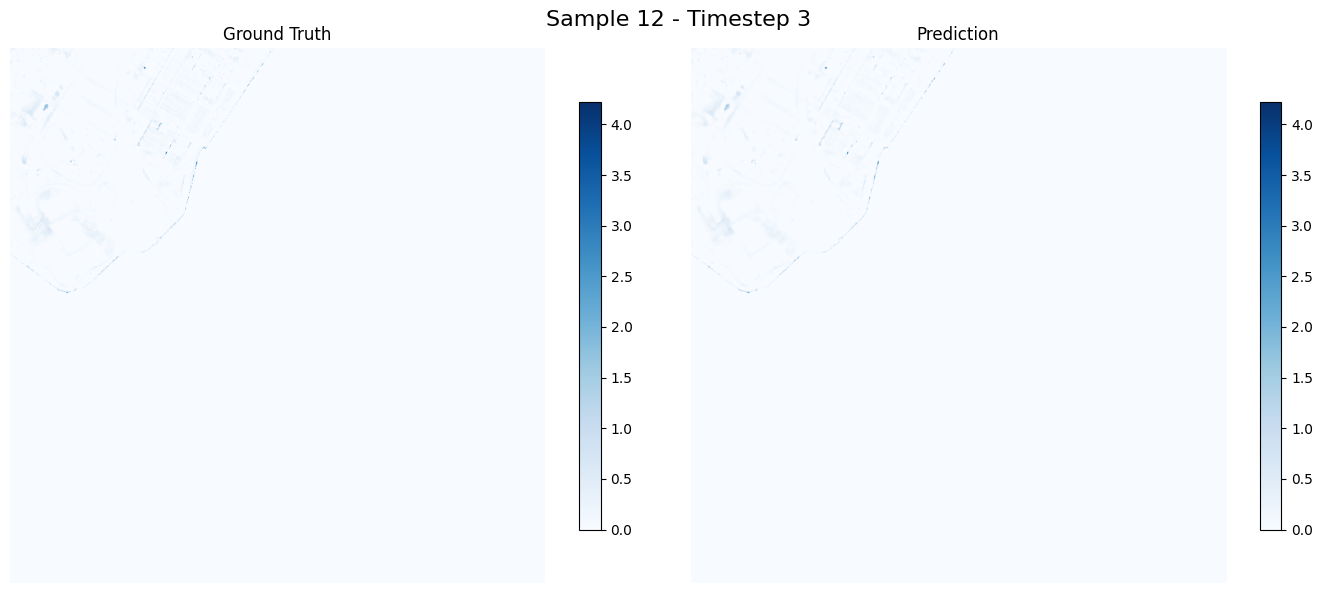


Sample 13 Prediction Stats:
  Min: 0.0
  Max: 4.6743813
  Mean: 0.006710006


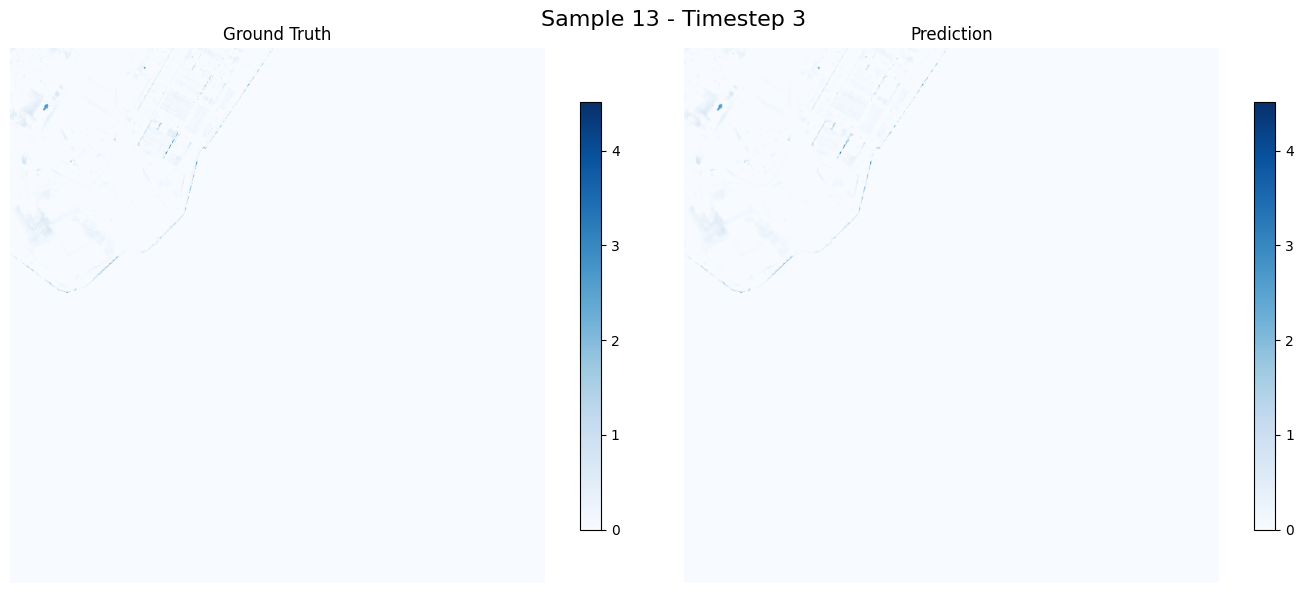


Sample 14 Prediction Stats:
  Min: 0.0
  Max: 0.49131966
  Mean: 0.0032071164


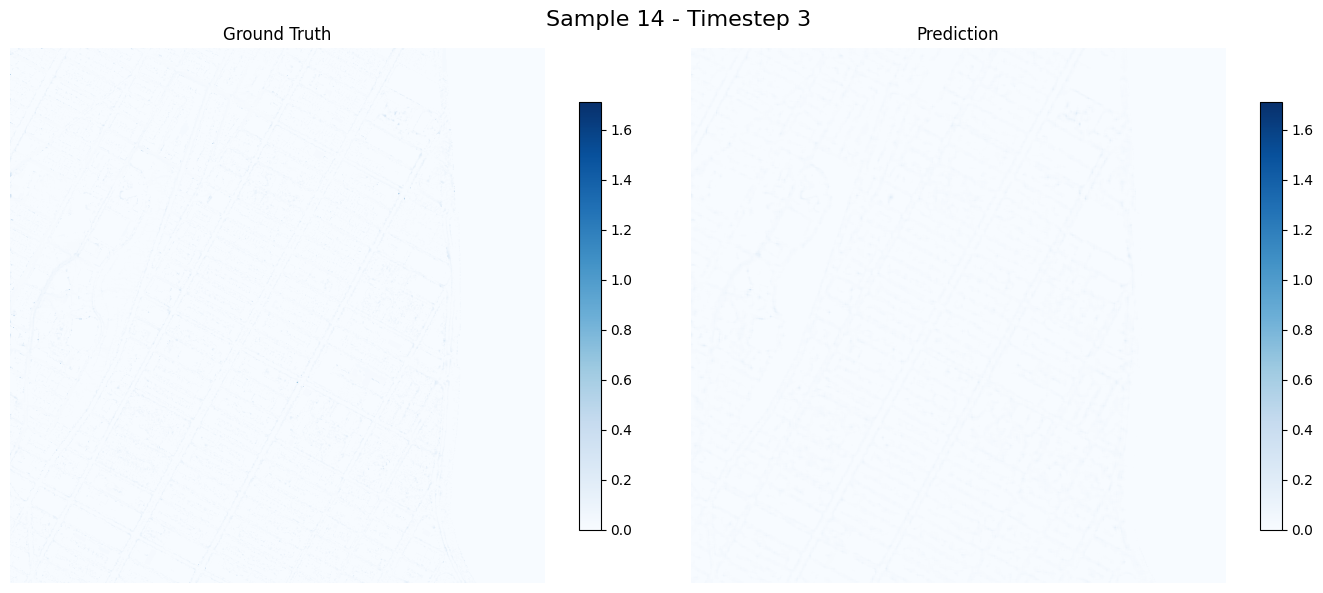


Sample 15 Prediction Stats:
  Min: 0.0
  Max: 4.864771
  Mean: 0.028137114


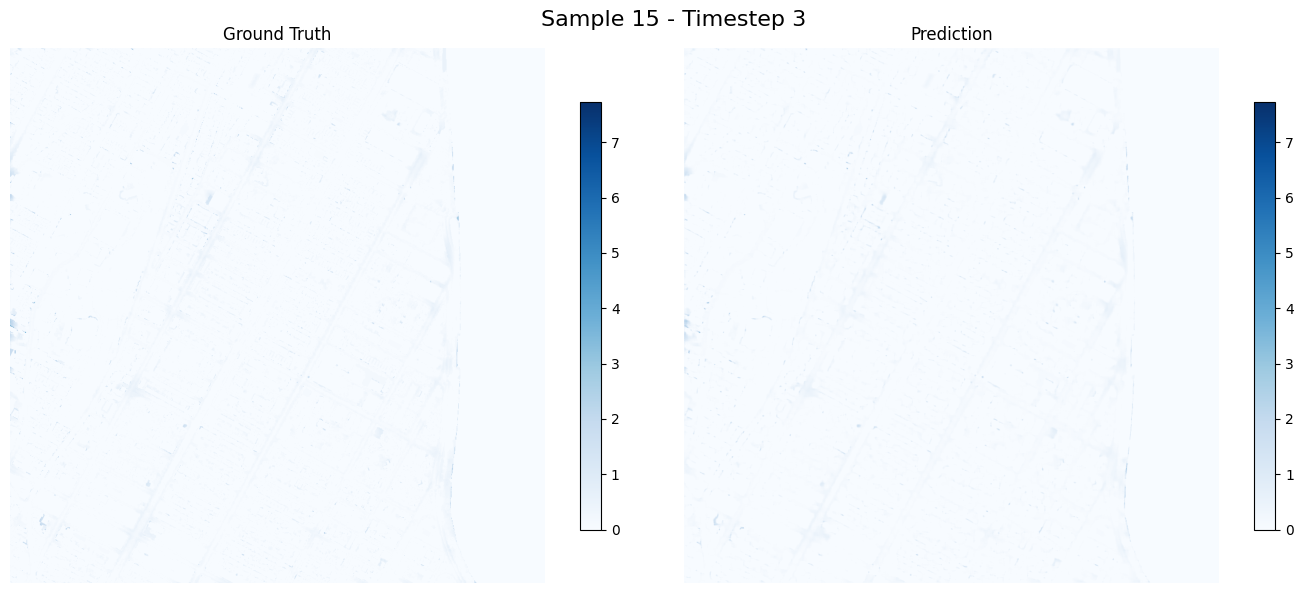


Sample 16 Prediction Stats:
  Min: 0.0
  Max: 5.0928555
  Mean: 0.040725965


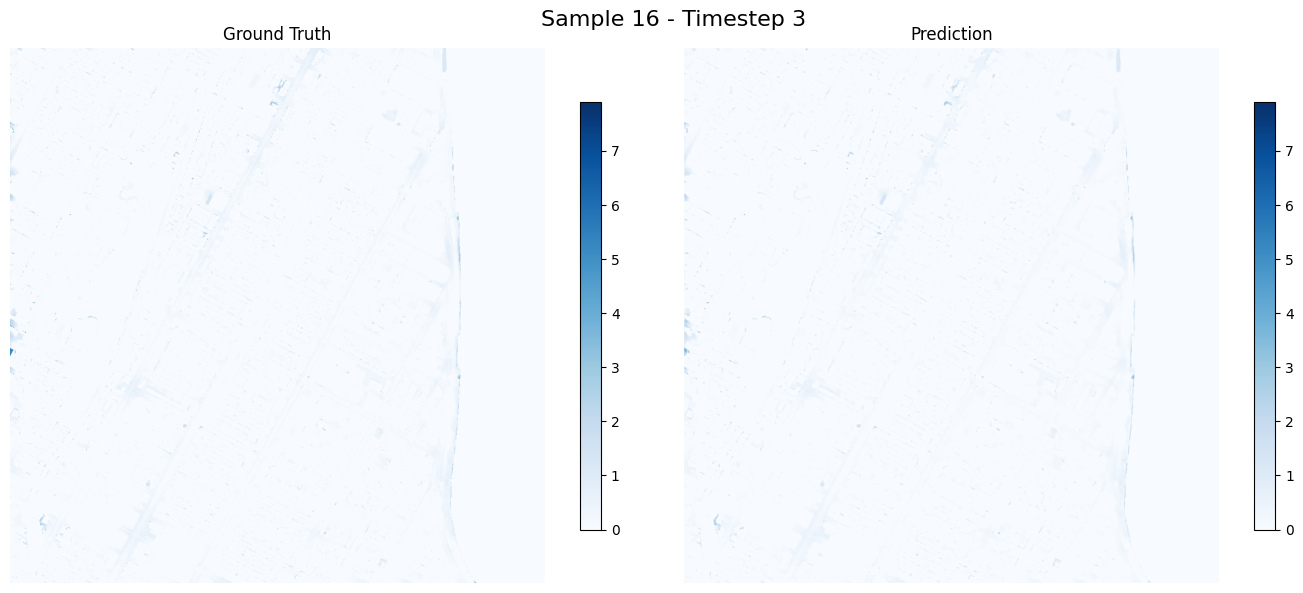


Sample 17 Prediction Stats:
  Min: 0.0
  Max: 5.271259
  Mean: 0.0116559835


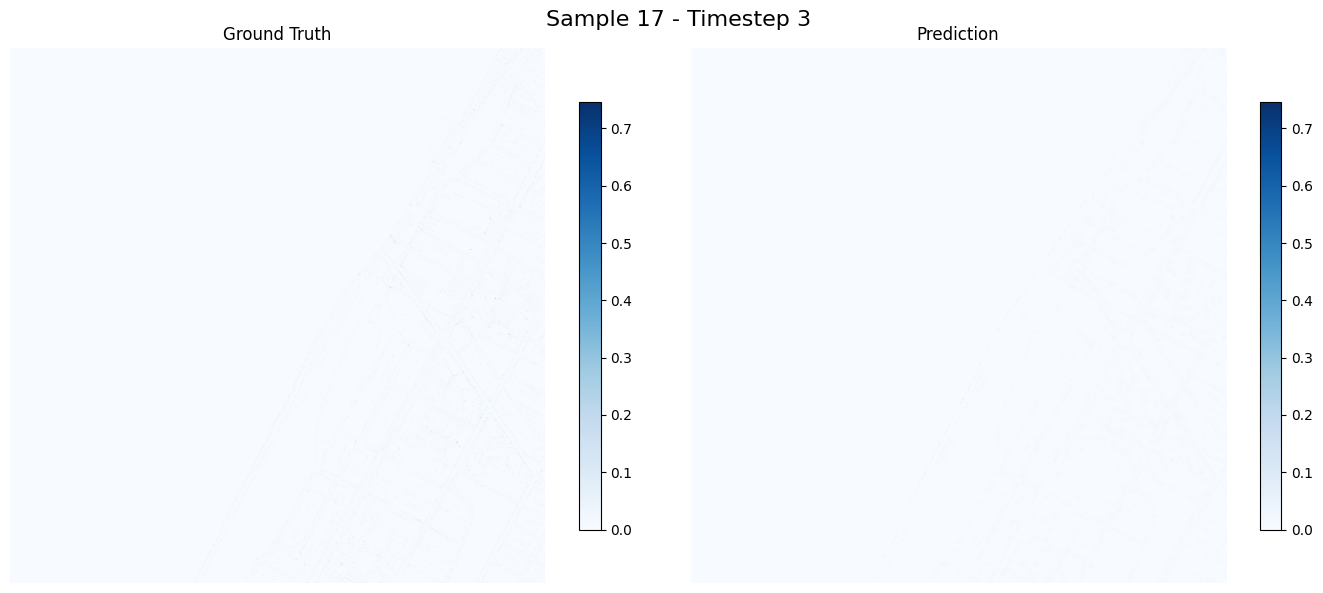


Sample 18 Prediction Stats:
  Min: 0.0
  Max: 3.3484347
  Mean: 0.009620728


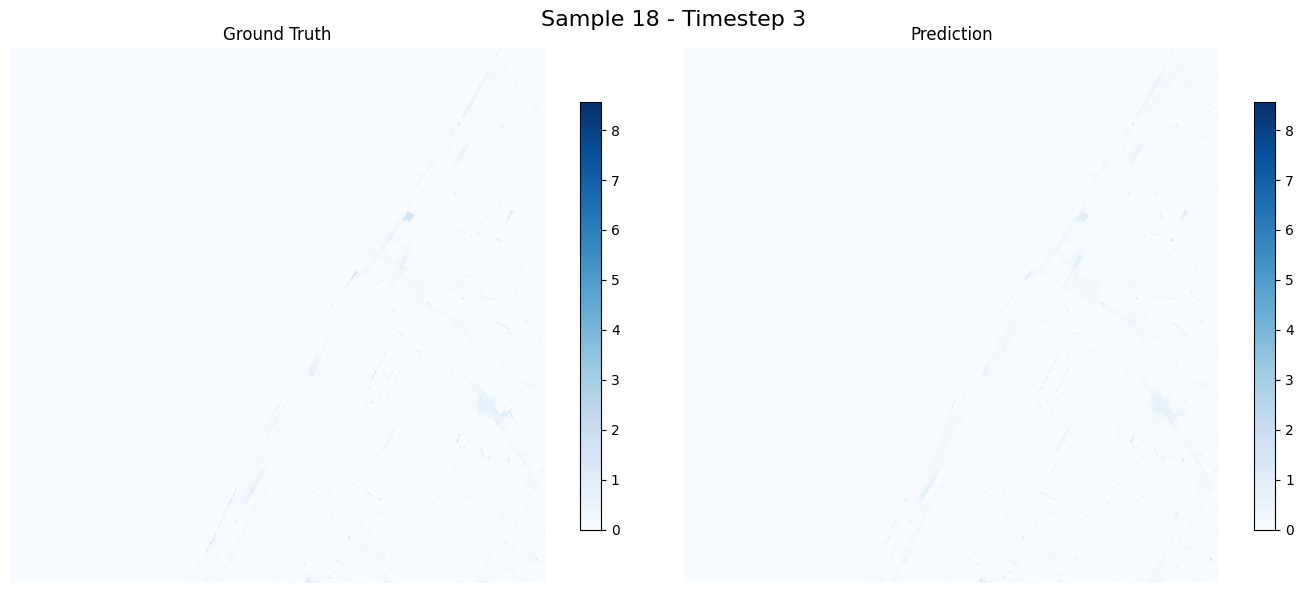


Sample 19 Prediction Stats:
  Min: 0.0
  Max: 4.539197
  Mean: 0.018426817


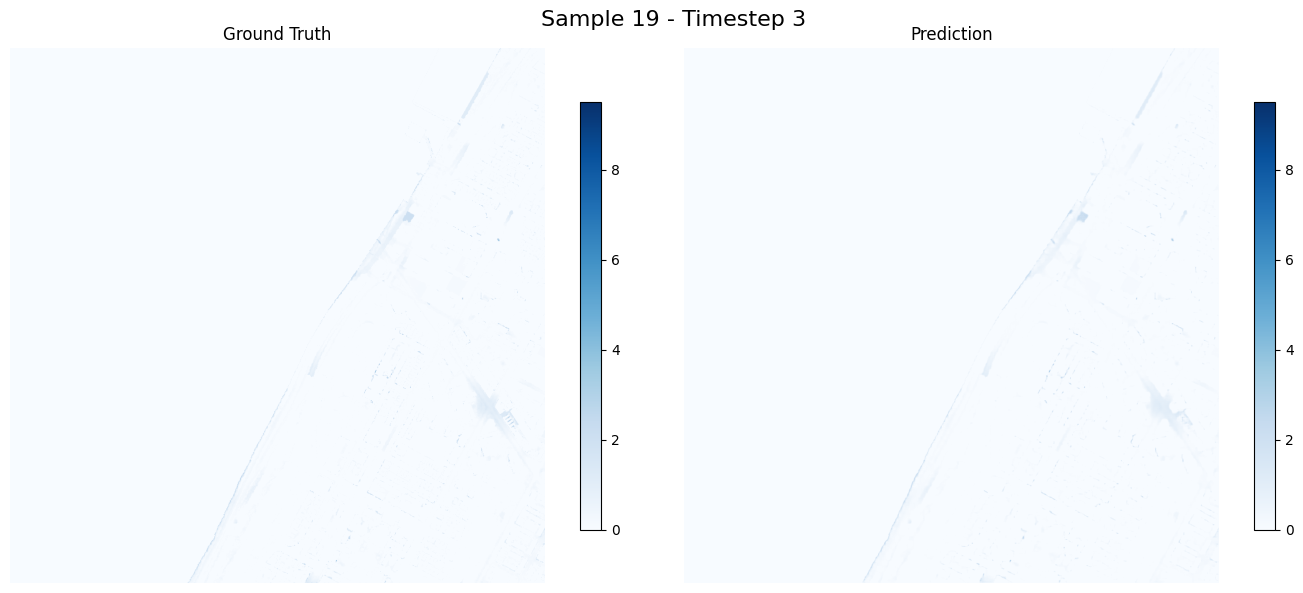


Sample 20 Prediction Stats:
  Min: 0.0
  Max: 4.479023
  Mean: 0.010940398


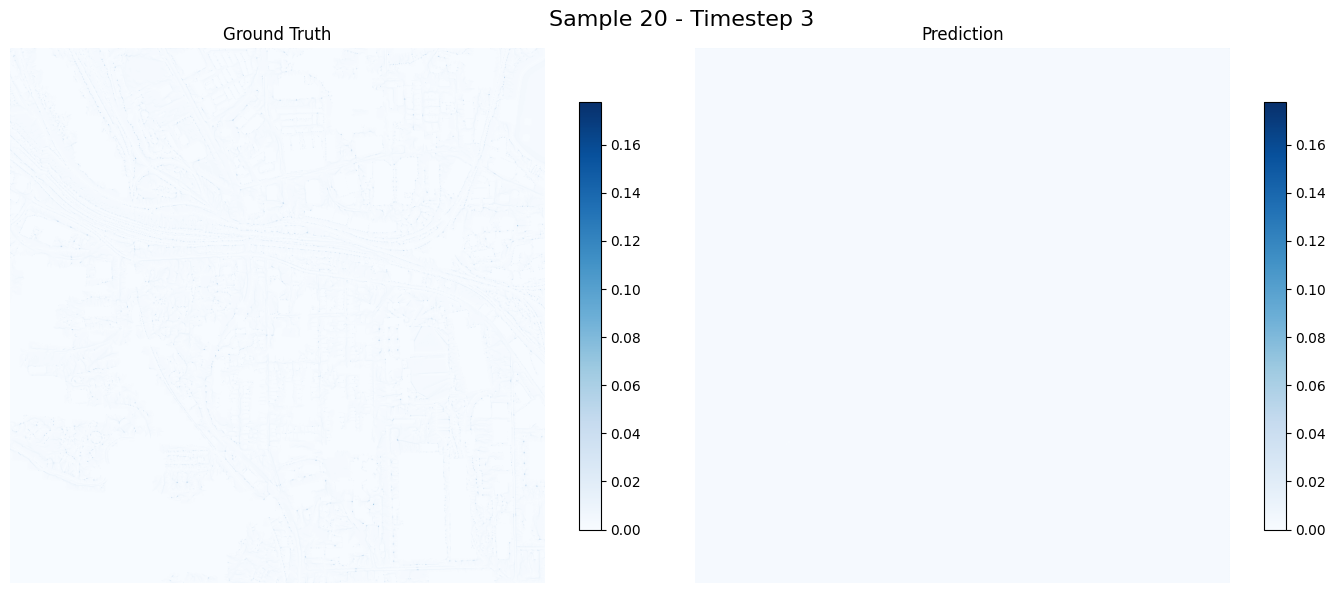

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants

# Path to trained model
model_path = "/home/vupparal/climateiq-cnn-2/logs/htune_project_20250828-143143/model"
model = tf.keras.models.load_model(model_path)

# Number of samples to visualize
n_samples = 20

# Loop through the dataset and predict
for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    print(f"\nSample {i+1} Prediction Stats:")
    print("  Min:", prediction.min())
    print("  Max:", prediction.max())
    print("  Mean:", prediction.mean())

    # Choose timestep to plot
    timestep = 3
    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = max(gt_t.max(), pred_t.max())

    # Plot Ground Truth and Prediction
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()


In [15]:
# ============================
# 🔧 BASIC SETTINGS
# ============================
from pathlib import Path
from usl_models.flood_ml.dataset import download_dataset, load_dataset_cached, load_prediction_dataset_cached

# 1) Set your simulation(s) here. For your test:
sim_names = ["Atlanta_Prediction"] 

# 2) File cache location (adjust if your notebook defines a different path)
filecache_dir = Path("./filecache")

# 3) Common dataset params (keep your existing values if already defined above)
dataset_split   = "train"          # used only for training sims
dataset_splits  = ["train"]        # used only in download_dataset for training sims
batch_size      = 4
n_flood_maps    = constants.N_FLOOD_MAPS
m_rainfall      = constants.M_RAINFALL
max_chunks      = None             # or an int if you want to limit

# Helper (mirrors the module’s logic; harmless if duplicated)
def _is_prediction_sim(name: str) -> bool:
    return "prediction" in name.lower()

# ============================
# 📥 STEP 1 — DOWNLOAD (run once)
# ============================
# Run this ONCE to populate the local filecache. Then comment it out for subsequent runs.
print(":inbox_tray: Downloading simulations into local cache...")
download_dataset(
    sim_names=sim_names,
    output_path=filecache_dir,
    dataset_splits=dataset_splits,  # ignored for prediction sims
)
print(":white_check_mark: Download complete.")
# After the first successful run, comment out the 3 lines above per Sally's guidance.

# ============================
# 📦 STEP 2 — LOAD FROM CACHE
# ============================
is_prediction_run = all(_is_prediction_sim(s) for s in sim_names)
is_training_run   = all(not _is_prediction_sim(s) for s in sim_names)

if not (is_prediction_run or is_training_run):
    raise ValueError(
        "Do not mix prediction and training sims in a single run. "
        "Load prediction sims and training sims in separate runs."
    )

if is_prediction_run:
    # ---- PREDICTION PATH (NO LABELS) ----
    assert len(sim_names) == 1, "Load one prediction sim at a time for clarity."
    pred_sim = sim_names[0]

    print(f":crystal_ball: Loading cached prediction dataset for {pred_sim} ...")
    ds_pred = load_prediction_dataset_cached(
        filecache_dir=filecache_dir,
        sim_name=pred_sim,
        batch_size=batch_size,
        n_flood_maps=n_flood_maps,
        m_rainfall=m_rainfall,
    )
    print(":white_check_mark: Prediction dataset ready. Elements are (features, metadata).")

    # ✅ Sanity check: ensure there are NO labels and shapes look right
    for features, meta in ds_pred.take(1):
        print("Feature keys:", list(features.keys()))
        print("geospatial:", features["geospatial"].shape)
        print("temporal:", features["temporal"].shape)
        print("spatiotemporal:", features["spatiotemporal"].shape)
        # meta contains info like {'feature_chunk': <str>, 'rainfall': <int>}
        print("metadata example:", {k: (v.numpy() if hasattr(v, "numpy") else v) for k, v in meta.items()})

else:
    # ---- TRAIN/VAL/TEST PATH (WITH LABELS) ----
    print(f":open_file_folder: Loading cached {dataset_split} dataset ...")
    ds = load_dataset_cached(
        filecache_dir=filecache_dir,
        sim_names=sim_names,
        dataset_split=dataset_split,
        batch_size=batch_size,
        n_flood_maps=n_flood_maps,
        m_rainfall=m_rainfall,
        max_chunks=max_chunks,
        shuffle=True,
    )
    print(":white_check_mark: Training dataset ready. Elements are (features, labels).")

    # ✅ Sanity check for training path
    for features, labels in ds.take(1):
        print("Feature keys:", list(features.keys()))
        print("labels:", labels.shape)


:inbox_tray: Downloading simulations into local cache...
[Prediction] Inputs-only download for: Atlanta_Prediction
[Prediction] Inputs-only download for: Atlanta_Prediction
  Trying prefix: gs://test-climateiq-study-area-feature-chunks/Atlanta_Prediction/
    ✓ Atlanta_Prediction/scaled_chunk_0_0.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_0.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_1.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_1.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_2.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_2.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_3.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_3.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_4.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_4.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_5.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_5.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_6.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_6.npy
    ✓ Atlanta_Prediction/scaled_chunk_1_0.npy -> fi

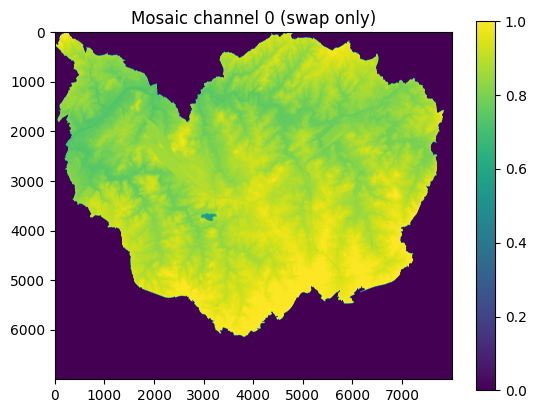

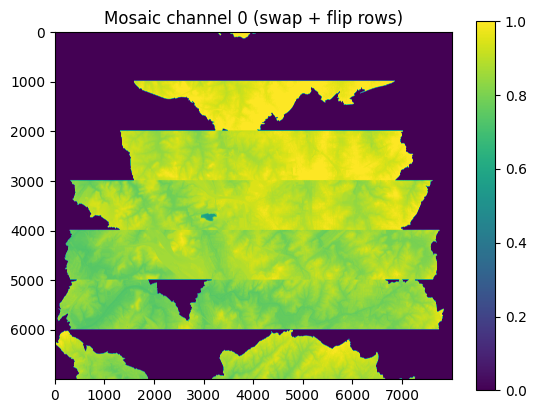

In [17]:
import re, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def pclip(img2d, lo=2, hi=98):
    x = img2d[np.isfinite(img2d)]
    if x.size == 0: return img2d
    lo_v, hi_v = np.percentile(x, [lo, hi])
    return np.clip((img2d - lo_v) / (hi_v - lo_v + 1e-12), 0, 1)

def _parse_tiles(sim_dir: Path, pattern=r"scaled_chunk_(\d+)_(\d+)\.npy"):
    rx = re.compile(pattern)
    tiles = []
    for p in Path(sim_dir).rglob("*.npy"):
        m = rx.match(p.name)
        if m:
            a, b = int(m.group(1)), int(m.group(2))
            tiles.append((a, b, p))
    if not tiles:
        raise ValueError(f"No tiles matched in {sim_dir}")
    return tiles

def _grid_and_shape(tiles):
    # load one tile
    sample = np.load(tiles[0][2])
    if sample.ndim != 3:
        raise ValueError(f"Tiles must be (H,W,C); got {sample.shape}")
    H, W, C = sample.shape
    return H, W, C

def _index_maps(tiles, use_swap=False):
    # build unique sorted lists given a mapping choice
    if use_swap:
        rows_list = sorted({b for a,b,_ in tiles})  # y
        cols_list = sorted({a for a,_,_ in tiles})  # x
    else:
        rows_list = sorted({a for a,_,_ in tiles})  # a as row
        cols_list = sorted({b for _,b,_ in tiles})  # b as col
    rpos = {rid:i for i,rid in enumerate(rows_list)}
    cpos = {cid:i for i,cid in enumerate(cols_list)}
    return rows_list, cols_list, rpos, cpos

def stitch(sim_dir: Path, swap=False, flip_rows=False, pattern=r"scaled_chunk_(\d+)_(\d+)\.npy"):
    tiles = _parse_tiles(sim_dir, pattern)
    H, W, C = _grid_and_shape(tiles)
    rows_list, cols_list, rpos, cpos = _index_maps(tiles, use_swap=swap)
    R, Cc = len(rows_list), len(cols_list)
    mosaic = np.zeros((R*H, Cc*W, C), dtype=np.float32)

    for a, b, p in tiles:
        arr = np.load(p)
        if swap:
            r_id, c_id = b, a
        else:
            r_id, c_id = a, b
        rr = rpos[r_id]
        cc = cpos[c_id]
        if flip_rows:
            rr = (R - 1) - rr
        mosaic[rr*H:(rr+1)*H, cc*W:(cc+1)*W, :] = arr
    return mosaic

# --- Try the two most likely layouts ---
SIM_DIR = Path(filecache_dir) / "Atlanta_Prediction"

mosaic_swap = stitch(SIM_DIR, swap=True, flip_rows=False)       # (x,y)
mosaic_swap_flip = stitch(SIM_DIR, swap=True, flip_rows=True)   # (x,y) with vertical flip

for title, img in [("swap only", mosaic_swap), ("swap + flip rows", mosaic_swap_flip)]:
    plt.figure()
    plt.title(f"Mosaic channel 0 ({title})")
    plt.imshow(pclip(img[:,:,0]))
    plt.colorbar()
    plt.show()
